In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.24
3.12.1
1.12.0


/tmp/ipykernel_3997564/734137169.py:27: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

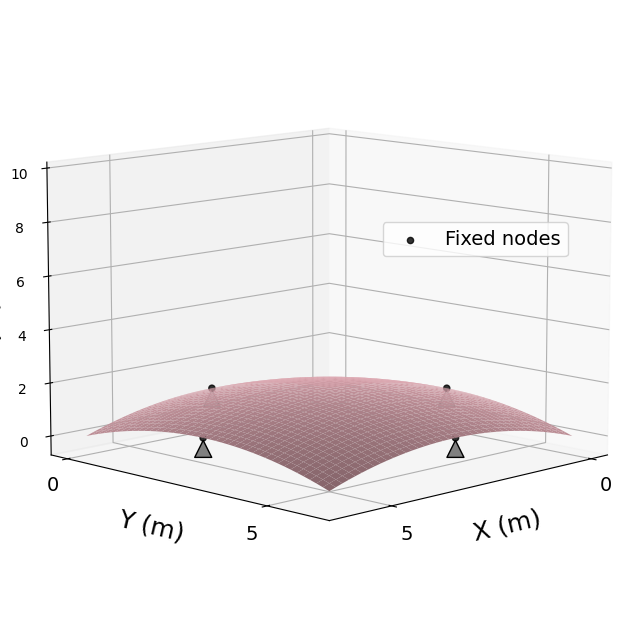

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

In [4]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that minimum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    norm_min =jnp.min(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    norm_max = jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    return (jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)-norm_min)/(norm_max-norm_min)

In [5]:
dis_b = dis_boundary(xs,ys,non_design_nodes)[design_nodes]
v_cen = v_centrality(xs,ys,non_design_nodes)

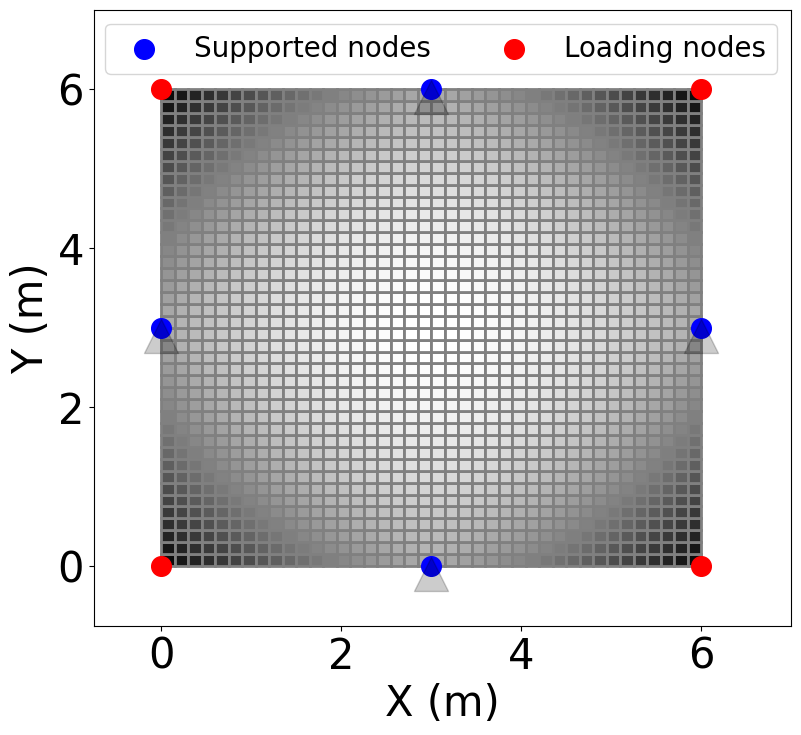

In [6]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = np.average(v_cen[cnct[i]])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

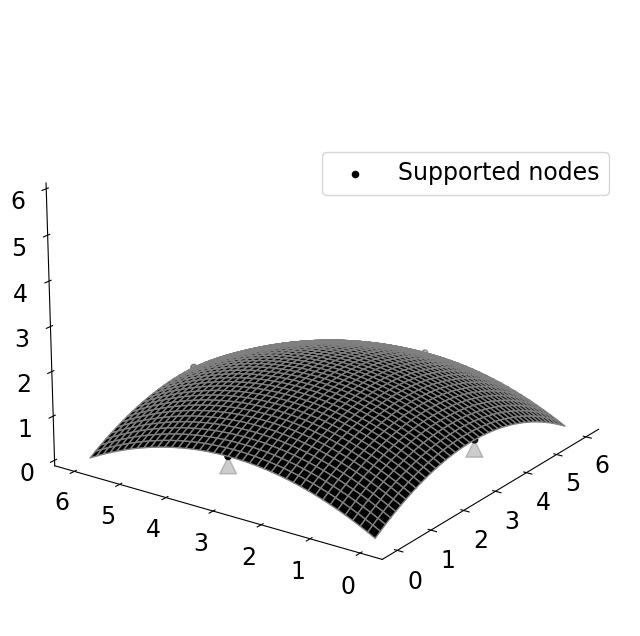

In [7]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -145)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#plt.axis('off')
plt.show()

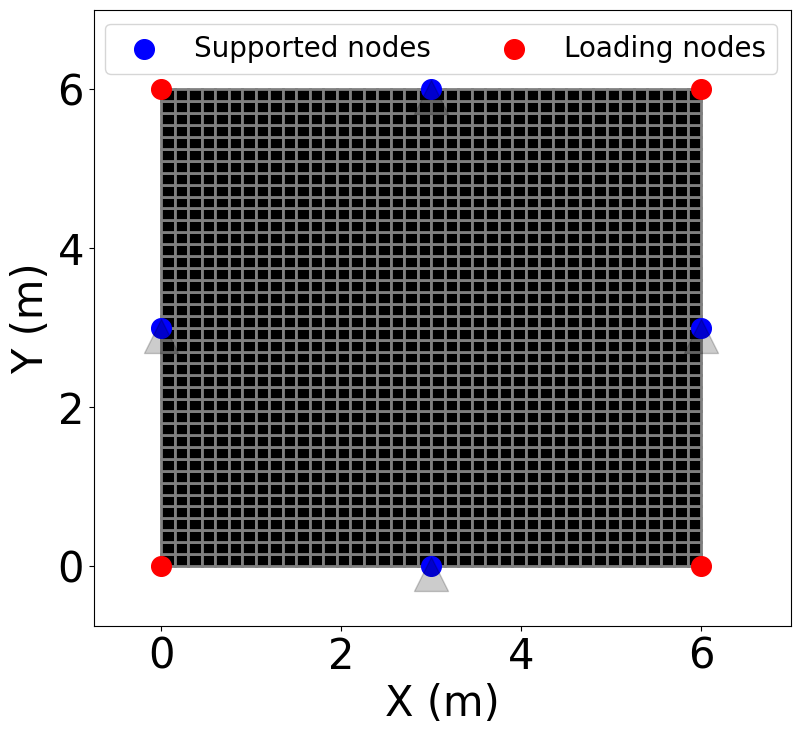

In [8]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [9]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [10]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [11]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

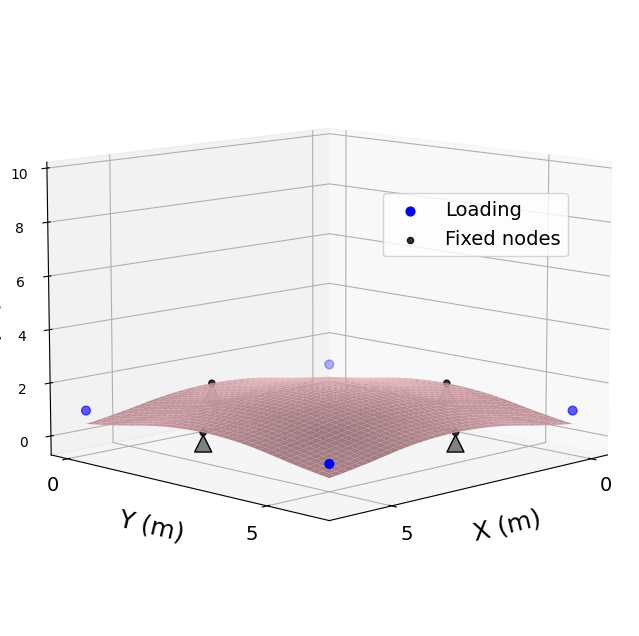

In [12]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [13]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [14]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [15]:
B_ij_shell.shape

(1600, 1600)

In [16]:
#W(A): total volume
def coeff_E(mu,p=7):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-0.75,7)
    ax.set_xlim(-0.75,7)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
    ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


    #cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    #cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20,ncol=2,loc=(0.01,0.9))

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


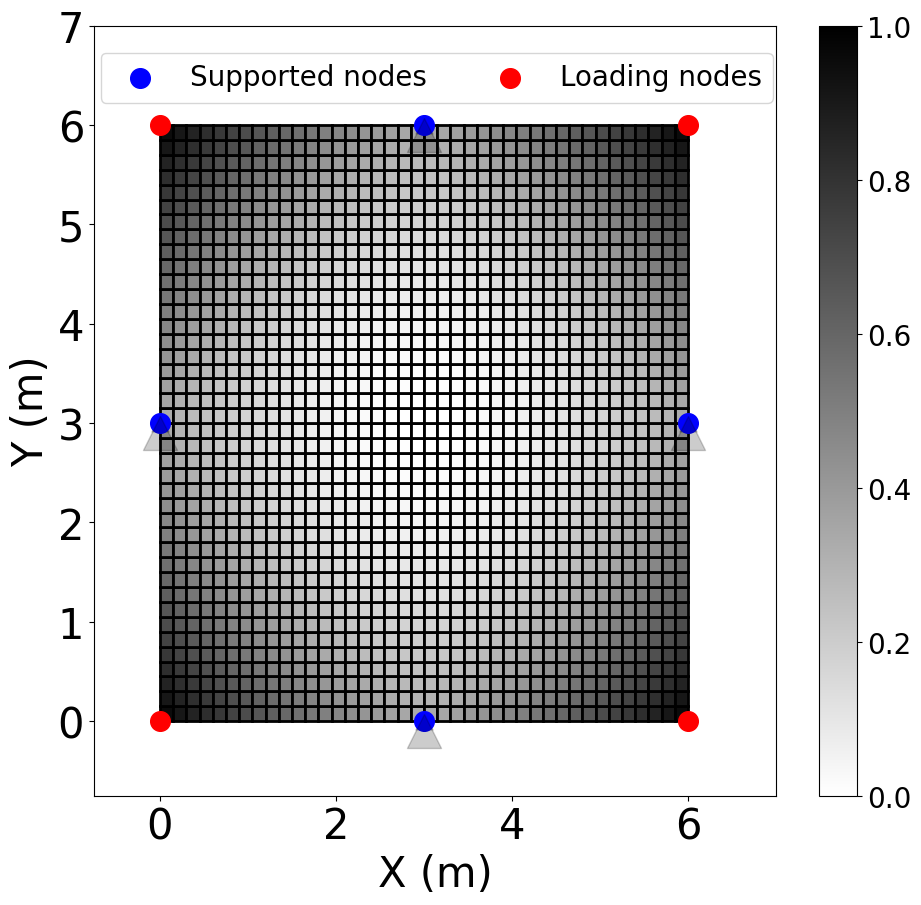

In [17]:
plt_plan(np.average(v_cen[cnct],axis=1) )

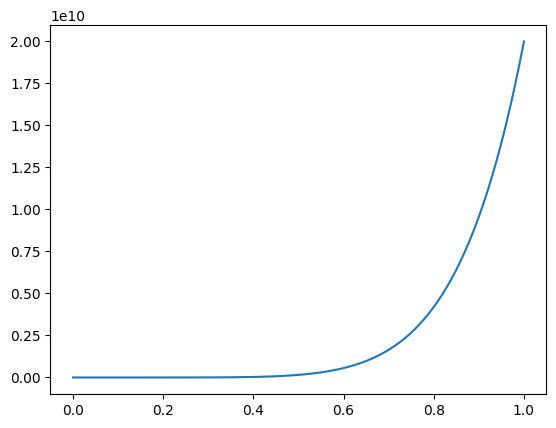

In [18]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [19]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [20]:
model.solve()

In [21]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# NN

1. Input of NN: 
* XY of nodes

2. Outoput:
* Z
* Density ?


In [22]:
import pymesh
from flax import linen as nn

In [58]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            #x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        x = nn.sigmoid(x) #Between 0 and 1
        return x

In [59]:
n_input = 1 #(X,Y) of each node
n_hidden = 100 # neurons
n_out = 2 #Z of each node & density
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.array([v_cen]).T
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [60]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [61]:
rng, init_rng = jax.random.split(rng, 2)
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [62]:
print(NN.tabulate(rng,inp,
                   compute_flops=True, compute_vjp_flops=True))


                                SimpleNN Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs    ┃ outputs   ┃ flops    ┃ vjp_flops ┃ params   ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│         │ SimpleNN │ float64[… │ float64[… │ 69291224 │ 207355616 │          │
├─────────┼──────────┼───────────┼───────────┼──────────┼───────────┼──────────┤
│ Dense_0 │ Dense    │ float64[… │ float64[… │ 504500   │ 1345300   │ bias:    │
│         │          │           │           │          │           │ float32… │
│         │          │           │           │          │           │ kernel:  │
│         │          │           │           │          │           │ float32… │
│         │          │           │           │          │           │          │
│         │          │           │           │          │           │ 200 (800 │
│         │          │     

In [63]:
import optax
optimizer = optax.adam(learning_rate=0.02)

In [64]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [65]:
def calculate_loss(state, params, inp,alpha=0.1, p_E=2):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_params = outs[:,0]
    node_rho_params = outs[:,1]
    
    #1. NN outputs to update shape (nodal-Z coordinate)
    p = jnp.array(zs).copy()
    p = p.at[design_nodes].set(og_p(node_params)) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    
    #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
    ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p_E) #Penalized Young's modulus
    #sso_model.update_eleparameter(E_step) # Update the model
    
    #3. Loss function: penalized compliance
    parameter_values = jnp.hstack([z,E_step])
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance/600
    loss2 = alpha*(jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    loss =  loss1 + loss2
    return loss#loss1,loss2,z,filtered_mu


def calculate_losses(state, params, inp,alpha=0.1, p_E=2):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_params = outs[:,0]
    node_rho_params = outs[:,1]
    
    #1. NN outputs to update shape (nodal-Z coordinate)
    p = jnp.array(zs).copy()
    p = p.at[design_nodes].set(og_p(node_params)) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    
    #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
    ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p_E) #Penalized Young's modulus
    #sso_model.update_eleparameter(E_step) # Update the model
    
    #3. Loss function: penalized compliance
    parameter_values = jnp.hstack([z,E_step])
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance
    loss2 = (jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    return loss1,loss2#loss1,loss2,z,filtered_mu

In [66]:
calculate_loss(model_state,params,inp)

Array(1.31671688, dtype=float64)

In [67]:
grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
loss, grads = grad_fn(model_state, model_state.params, inp)

In [68]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp,alpha=0.1, p=2):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp,alpha, p)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [42]:
%timeit train_step(model_state, inp)

2.82 s ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
loss_list =[]
comp_list =[]
v_list =[]
def train_model(state, num_epochs=200):
    alpha = 0.1
    p = 2
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        
        if alpha < 100:
            alpha = 0.1 +len(loss_list) * 0.05
        if p<8:
            p = 2 + 0.06*len(loss_list)
        print('Iter{}, alpha={}, p={}'.format(len(loss_list),alpha,p))
        state, loss = train_step(state, inp,alpha,p)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
        loss_list.append(loss)
        
        l1,l2 = calculate_losses(state, state.params,inp,alpha,p)
        comp_list.append(l1)
        v_list.append(l2)
        if len(loss_list)%5==0:
            i = len(loss_list)
            
            outs = state.apply_fn(state.params, inp) #shape (n_node,2)
            node_params = outs[:,0]
            node_rho_params = outs[:,1]



            #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.

            #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
            ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
            filtered_mu = B_ij_shell@ele_params
            E_step = coeff_E(filtered_mu) #Penalized Young's modulus
            print(jnp.sum(ele_params))
            
            plt_plan(filtered_mu,i)
    return state

  0%|          | 0/105 [00:00<?, ?it/s]

Iter0, alpha=0.1, p=2.0
Train epoch 2  ,loss:1.3167168778260279


  1%|          | 1/105 [00:42<1:13:38, 42.48s/it]

Iter1, alpha=0.15000000000000002, p=2.06
Train epoch 3  ,loss:0.2823533317152034


  2%|▏         | 2/105 [00:46<34:29, 20.09s/it]  

Iter2, alpha=0.2, p=2.12
Train epoch 4  ,loss:0.24303504849550125


  3%|▎         | 3/105 [00:51<21:59, 12.93s/it]

Iter3, alpha=0.25, p=2.18
Train epoch 5  ,loss:0.3271837600109997


  4%|▍         | 4/105 [00:55<16:06,  9.57s/it]

Iter4, alpha=0.30000000000000004, p=2.24
Train epoch 6  ,loss:0.388407020471782
1495.1267301220446


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


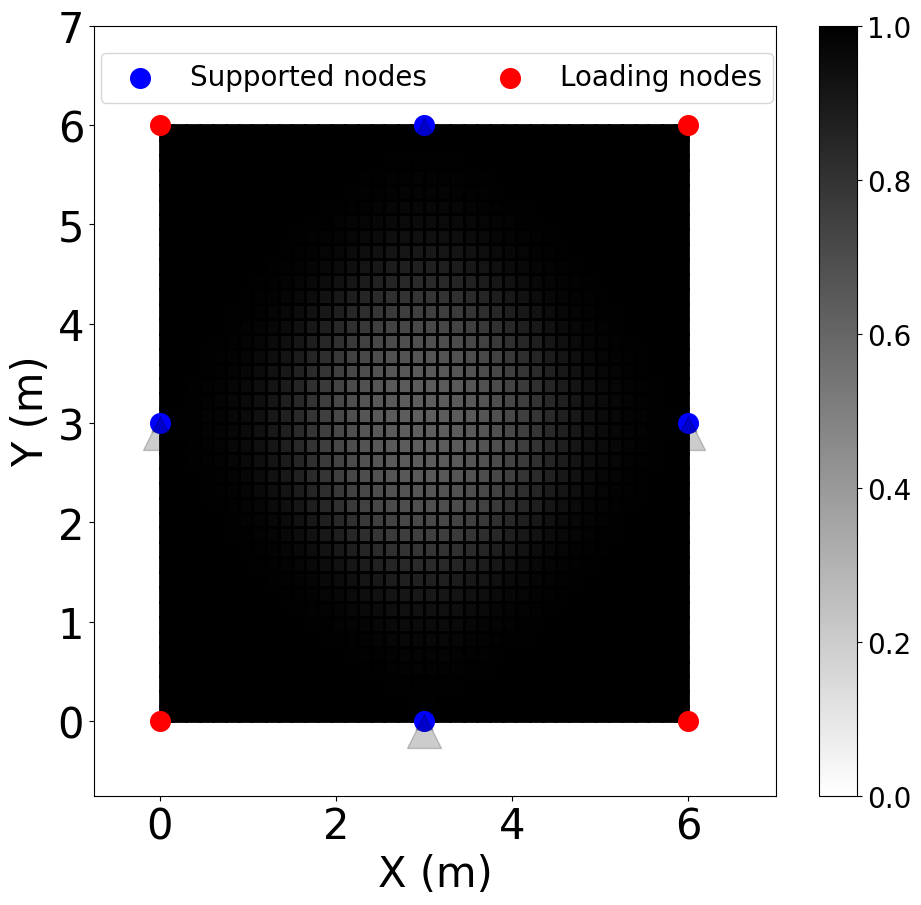

  5%|▍         | 5/105 [01:01<13:33,  8.14s/it]

Iter5, alpha=0.35, p=2.3
Train epoch 7  ,loss:0.4224562240786217


  6%|▌         | 6/105 [01:05<11:19,  6.86s/it]

Iter6, alpha=0.4, p=2.36
Train epoch 8  ,loss:0.42832755630909775


  7%|▋         | 7/105 [01:10<09:54,  6.06s/it]

Iter7, alpha=0.45000000000000007, p=2.42
Train epoch 9  ,loss:0.39718981845152707


  8%|▊         | 8/105 [01:14<08:57,  5.54s/it]

Iter8, alpha=0.5, p=2.48
Train epoch 10  ,loss:0.29784138207938327


  9%|▊         | 9/105 [01:18<08:18,  5.19s/it]

Iter9, alpha=0.55, p=2.54
Train epoch 11  ,loss:0.11146514410151905
910.8752820331397


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


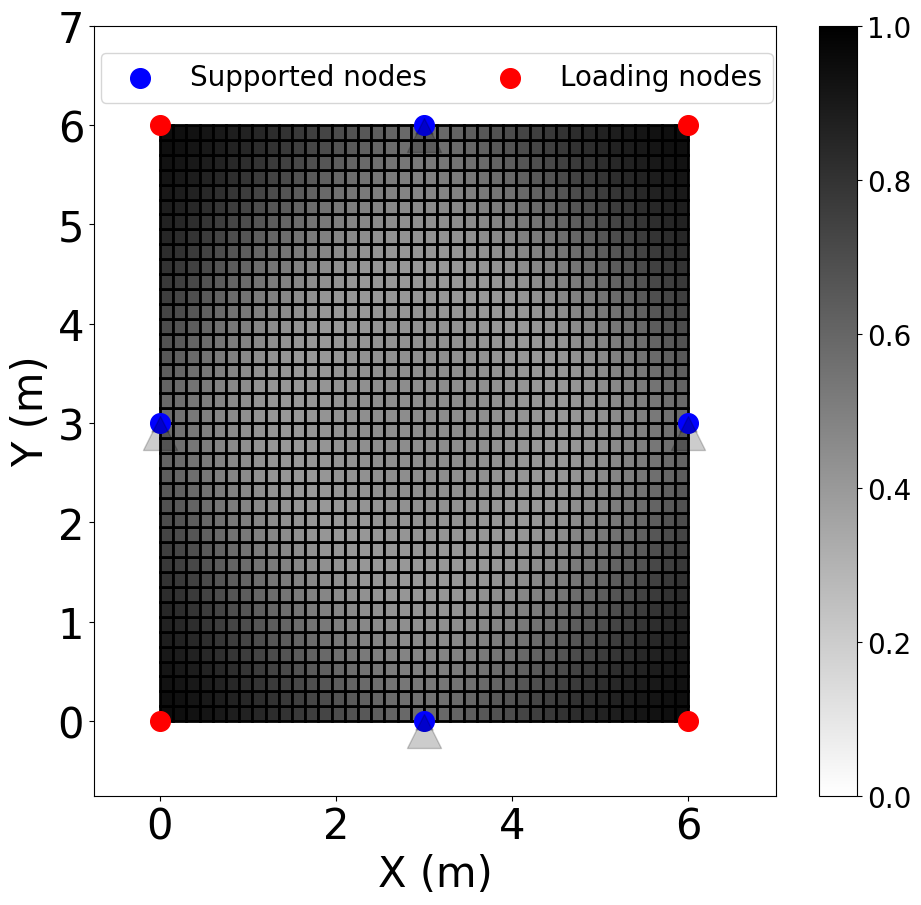

 10%|▉         | 10/105 [01:24<08:37,  5.44s/it]

Iter10, alpha=0.6, p=2.6
Train epoch 12  ,loss:0.07547163208822595


 10%|█         | 11/105 [01:29<08:02,  5.13s/it]

Iter11, alpha=0.65, p=2.66
Train epoch 13  ,loss:0.07505661313724794


 11%|█▏        | 12/105 [01:33<07:37,  4.92s/it]

Iter12, alpha=0.7000000000000001, p=2.7199999999999998
Train epoch 14  ,loss:0.05350246579355996


 12%|█▏        | 13/105 [01:38<07:19,  4.78s/it]

Iter13, alpha=0.75, p=2.7800000000000002
Train epoch 15  ,loss:0.04594429536570094


 13%|█▎        | 14/105 [01:42<07:05,  4.68s/it]

Iter14, alpha=0.8, p=2.84
Train epoch 16  ,loss:0.04480473955500226
868.5699258496568


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


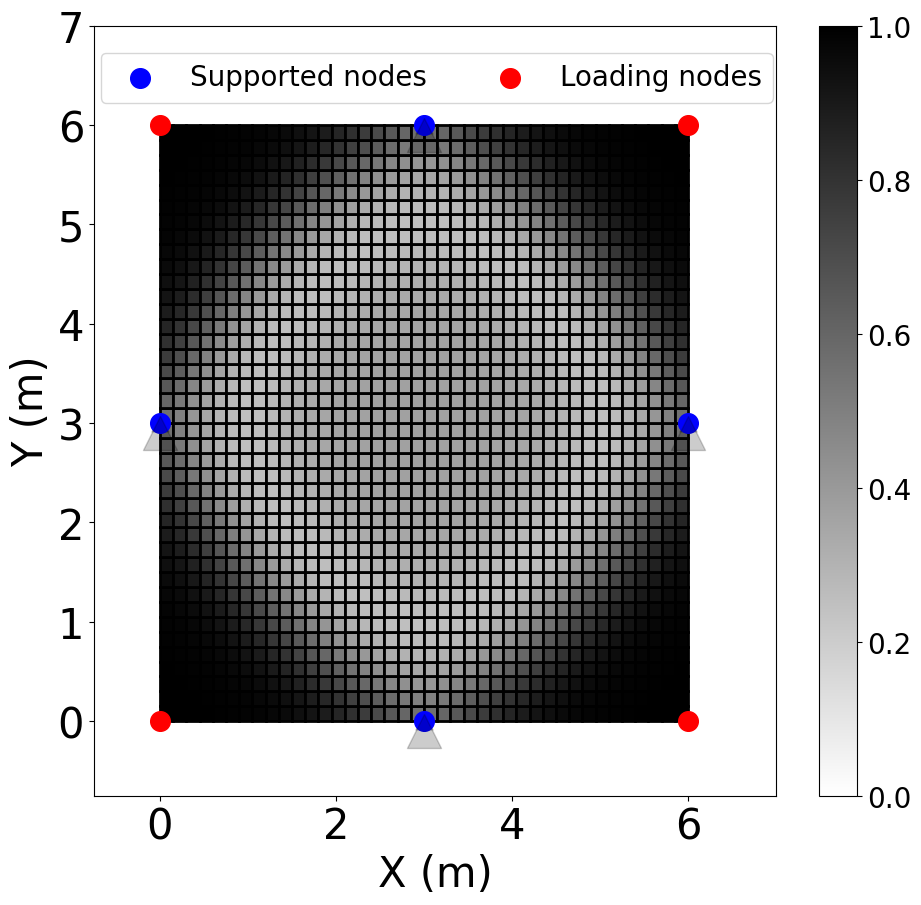

 14%|█▍        | 15/105 [01:48<07:27,  4.97s/it]

Iter15, alpha=0.85, p=2.9
Train epoch 17  ,loss:0.03852635236331193


 15%|█▌        | 16/105 [01:52<07:07,  4.80s/it]

Iter16, alpha=0.9, p=2.96
Train epoch 18  ,loss:0.03703320464525262


 16%|█▌        | 17/105 [01:57<06:52,  4.69s/it]

Iter17, alpha=0.9500000000000001, p=3.02
Train epoch 19  ,loss:0.037495833476896


 17%|█▋        | 18/105 [02:01<06:40,  4.61s/it]

Iter18, alpha=1.0, p=3.08
Train epoch 20  ,loss:0.03243989848333275


 18%|█▊        | 19/105 [02:06<06:31,  4.55s/it]

Iter19, alpha=1.05, p=3.1399999999999997
Train epoch 21  ,loss:0.0352174527249411
832.9741283095432


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


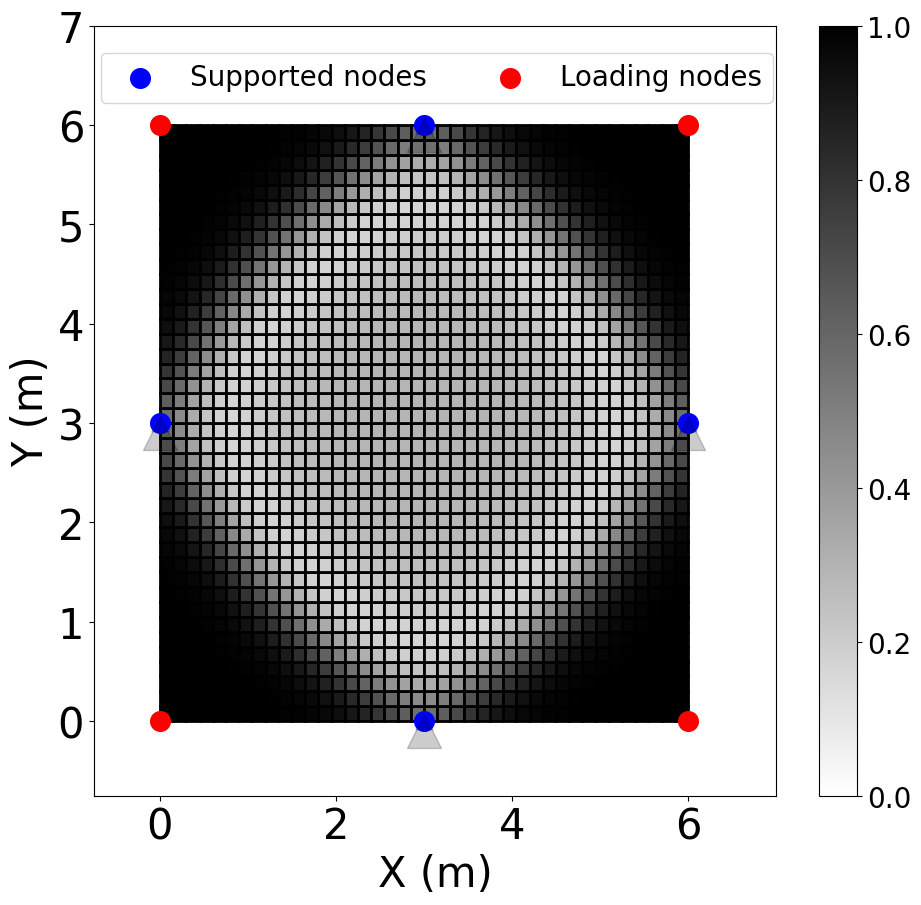

 19%|█▉        | 20/105 [02:11<06:54,  4.88s/it]

Iter20, alpha=1.1, p=3.2
Train epoch 22  ,loss:0.03192806786973212


 20%|██        | 21/105 [02:16<06:37,  4.73s/it]

Iter21, alpha=1.1500000000000001, p=3.26
Train epoch 23  ,loss:0.03037041128378061


 21%|██        | 22/105 [02:20<06:24,  4.63s/it]

Iter22, alpha=1.2000000000000002, p=3.32
Train epoch 24  ,loss:0.03277239977290652


 22%|██▏       | 23/105 [02:24<06:14,  4.56s/it]

Iter23, alpha=1.2500000000000002, p=3.38
Train epoch 25  ,loss:0.029370802429635617


 23%|██▎       | 24/105 [02:29<06:05,  4.51s/it]

Iter24, alpha=1.3000000000000003, p=3.44
Train epoch 26  ,loss:0.02863232919615208
837.4579954968704


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


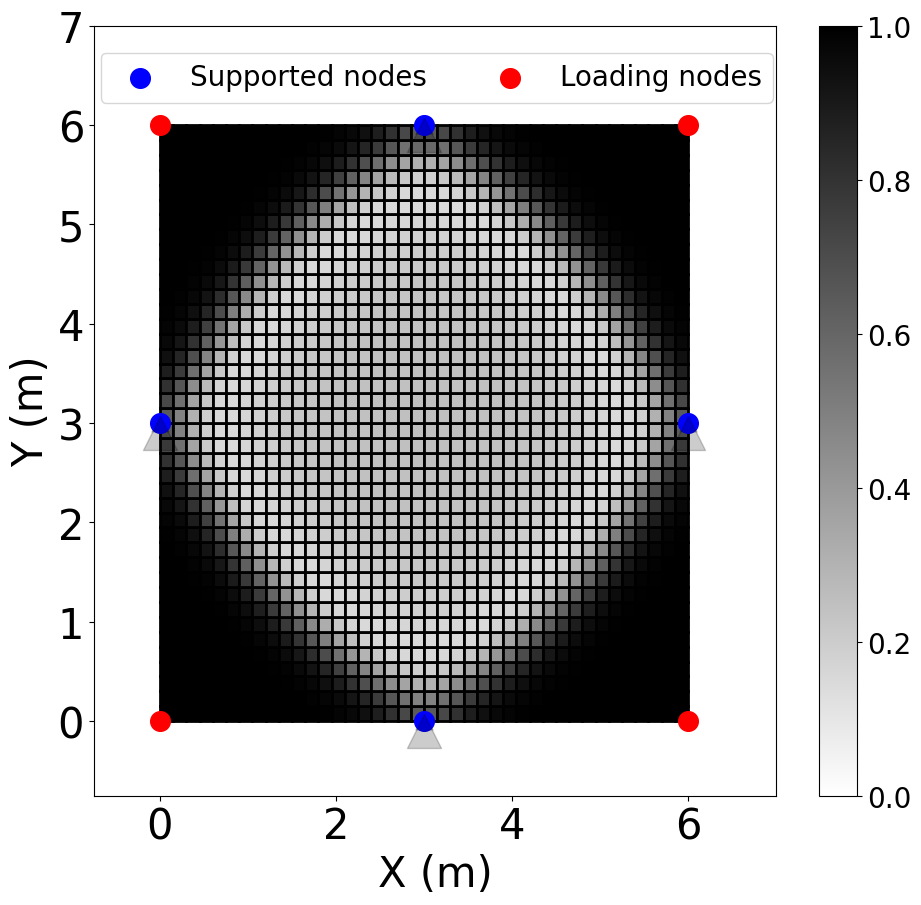

 24%|██▍       | 25/105 [02:35<06:39,  4.99s/it]

Iter25, alpha=1.35, p=3.5
Train epoch 27  ,loss:0.029670274727867985


 25%|██▍       | 26/105 [02:39<06:20,  4.82s/it]

Iter26, alpha=1.4000000000000001, p=3.56
Train epoch 28  ,loss:0.027911424341242403


 26%|██▌       | 27/105 [02:44<06:06,  4.70s/it]

Iter27, alpha=1.4500000000000002, p=3.62
Train epoch 29  ,loss:0.027103085776507652


 27%|██▋       | 28/105 [02:48<05:54,  4.61s/it]

Iter28, alpha=1.5000000000000002, p=3.6799999999999997
Train epoch 30  ,loss:0.028304713568996286


 28%|██▊       | 29/105 [02:53<05:45,  4.55s/it]

Iter29, alpha=1.5500000000000003, p=3.74
Train epoch 31  ,loss:0.026749025063831023
815.8183382089754


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


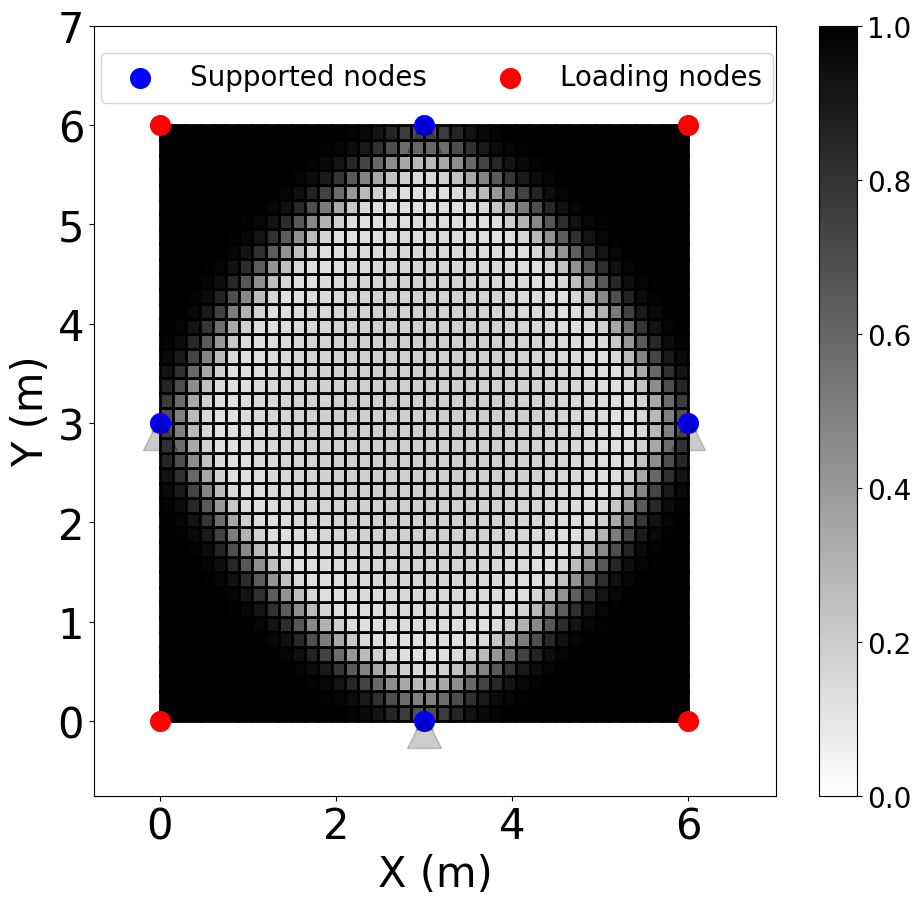

 29%|██▊       | 30/105 [02:58<06:05,  4.87s/it]

Iter30, alpha=1.6, p=3.8
Train epoch 32  ,loss:0.025932127219191026


 30%|██▉       | 31/105 [03:03<05:50,  4.73s/it]

Iter31, alpha=1.6500000000000001, p=3.86
Train epoch 33  ,loss:0.026514260025430034


 30%|███       | 32/105 [03:07<05:38,  4.63s/it]

Iter32, alpha=1.7000000000000002, p=3.92
Train epoch 34  ,loss:0.02554491561320168


 31%|███▏      | 33/105 [03:11<05:28,  4.57s/it]

Iter33, alpha=1.7500000000000002, p=3.98
Train epoch 35  ,loss:0.024818059219832565


 32%|███▏      | 34/105 [03:16<05:20,  4.52s/it]

Iter34, alpha=1.8000000000000003, p=4.04
Train epoch 36  ,loss:0.02535144356018543
792.6440040264296


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


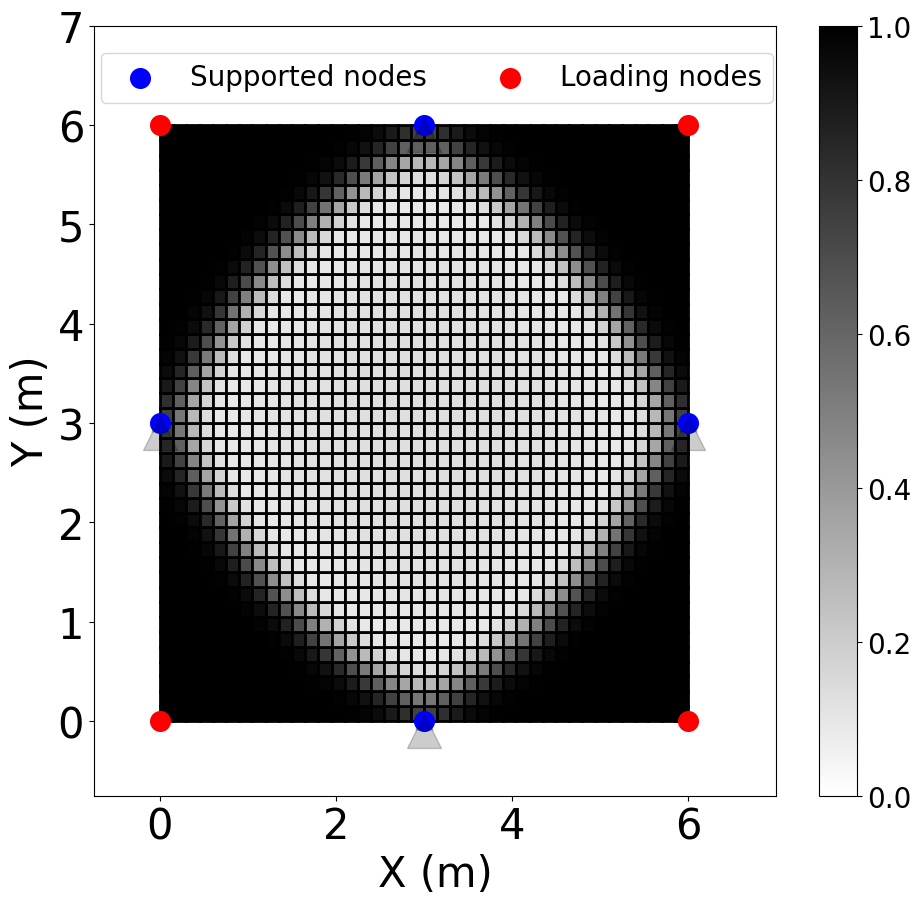

 33%|███▎      | 35/105 [03:22<05:47,  4.97s/it]

Iter35, alpha=1.85, p=4.1
Train epoch 37  ,loss:0.024629724124872215


 34%|███▍      | 36/105 [03:26<05:31,  4.80s/it]

Iter36, alpha=1.9000000000000001, p=4.16
Train epoch 38  ,loss:0.024046288502425118


 35%|███▌      | 37/105 [03:31<05:18,  4.68s/it]

Iter37, alpha=1.9500000000000002, p=4.22
Train epoch 39  ,loss:0.024400235206724304


 36%|███▌      | 38/105 [03:35<05:08,  4.60s/it]

Iter38, alpha=2.0, p=4.279999999999999
Train epoch 40  ,loss:0.02396795773607062


 37%|███▋      | 39/105 [03:39<04:59,  4.54s/it]

Iter39, alpha=2.0500000000000003, p=4.34
Train epoch 41  ,loss:0.02352331164649009


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


789.9753250566375


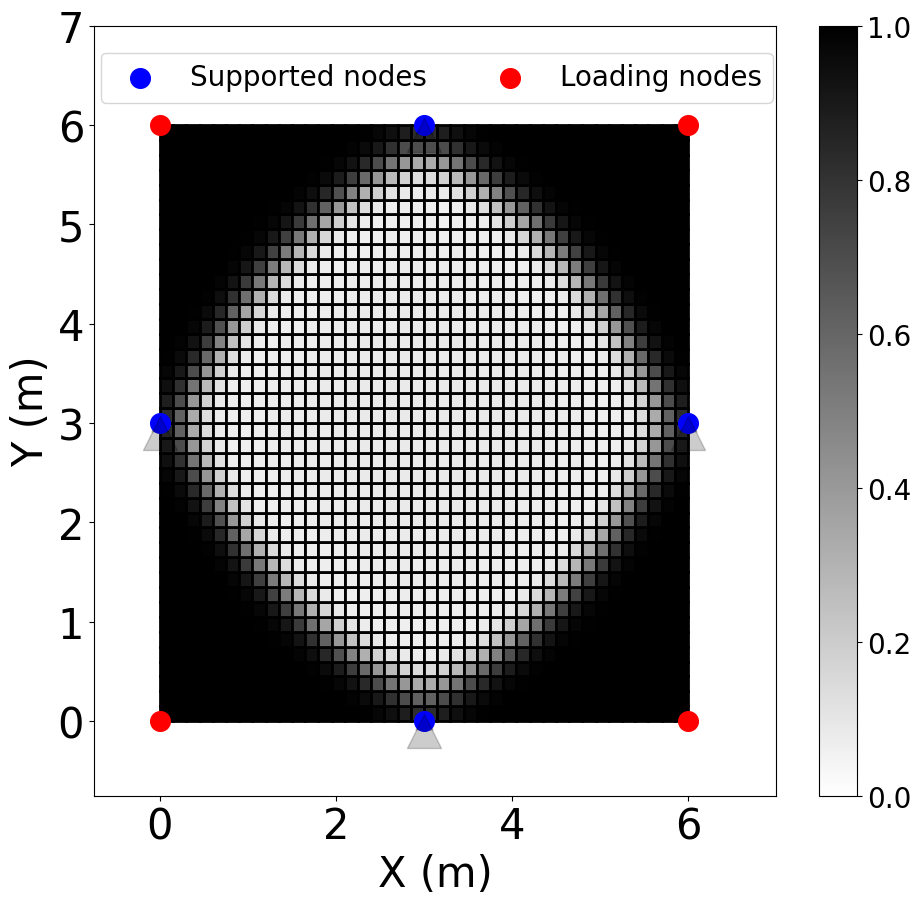

 38%|███▊      | 40/105 [03:45<05:16,  4.86s/it]

Iter40, alpha=2.1, p=4.4
Train epoch 42  ,loss:0.02383733238474599


 39%|███▉      | 41/105 [03:49<05:01,  4.72s/it]

Iter41, alpha=2.1500000000000004, p=4.46
Train epoch 43  ,loss:0.02354655690767256


 40%|████      | 42/105 [03:54<04:51,  4.63s/it]

Iter42, alpha=2.2, p=4.52
Train epoch 44  ,loss:0.02320429136729962


 41%|████      | 43/105 [03:58<04:42,  4.56s/it]

Iter43, alpha=2.25, p=4.58
Train epoch 45  ,loss:0.02344142444249537


 42%|████▏     | 44/105 [04:03<04:35,  4.51s/it]

Iter44, alpha=2.3000000000000003, p=4.64
Train epoch 46  ,loss:0.023216185840145048
798.8867325470796


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


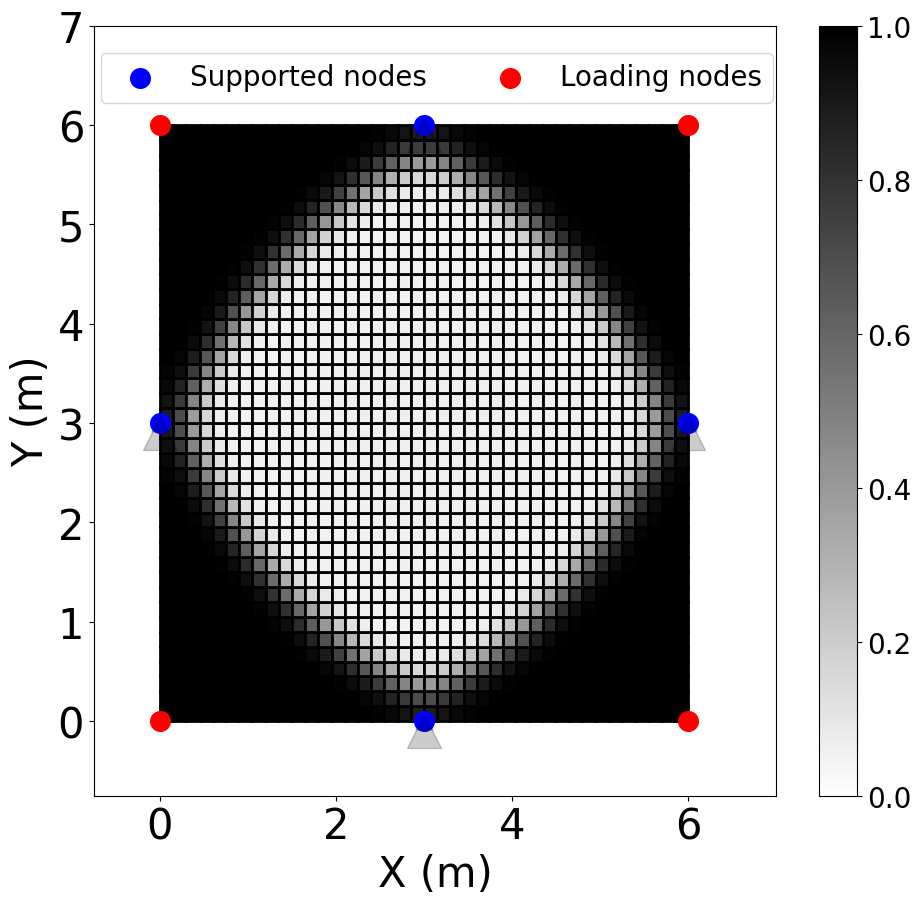

 43%|████▎     | 45/105 [04:08<04:50,  4.84s/it]

Iter45, alpha=2.35, p=4.699999999999999
Train epoch 47  ,loss:0.022971747757340184


 44%|████▍     | 46/105 [04:13<04:37,  4.71s/it]

Iter46, alpha=2.4000000000000004, p=4.76
Train epoch 48  ,loss:0.023126410467278556


 45%|████▍     | 47/105 [04:17<04:27,  4.61s/it]

Iter47, alpha=2.45, p=4.82
Train epoch 49  ,loss:0.0229371664091184


 46%|████▌     | 48/105 [04:21<04:19,  4.54s/it]

Iter48, alpha=2.5000000000000004, p=4.88
Train epoch 50  ,loss:0.022743693444805896


 47%|████▋     | 49/105 [04:26<04:11,  4.50s/it]

Iter49, alpha=2.5500000000000003, p=4.9399999999999995
Train epoch 51  ,loss:0.022829428515015186
804.1236815828465


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


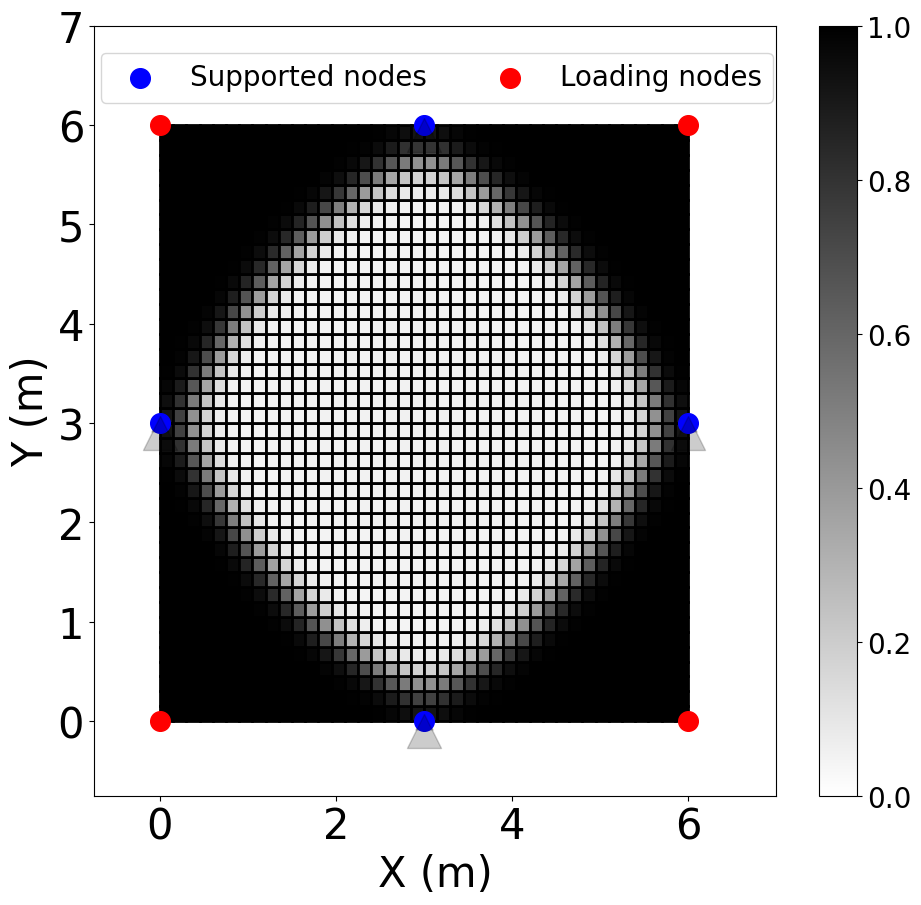

 48%|████▊     | 50/105 [04:32<04:33,  4.97s/it]

Iter50, alpha=2.6, p=5.0
Train epoch 52  ,loss:0.022615937232345538


 49%|████▊     | 51/105 [04:36<04:19,  4.80s/it]

Iter51, alpha=2.6500000000000004, p=5.0600000000000005
Train epoch 53  ,loss:0.022458661489140056


 50%|████▉     | 52/105 [04:41<04:08,  4.68s/it]

Iter52, alpha=2.7, p=5.12
Train epoch 54  ,loss:0.022478580771273564


 50%|█████     | 53/105 [04:45<03:58,  4.60s/it]

Iter53, alpha=2.7500000000000004, p=5.18
Train epoch 55  ,loss:0.022185416593954285


 51%|█████▏    | 54/105 [04:49<03:51,  4.53s/it]

Iter54, alpha=2.8000000000000003, p=5.24
Train epoch 56  ,loss:0.022127218452515602
805.8341948800457


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


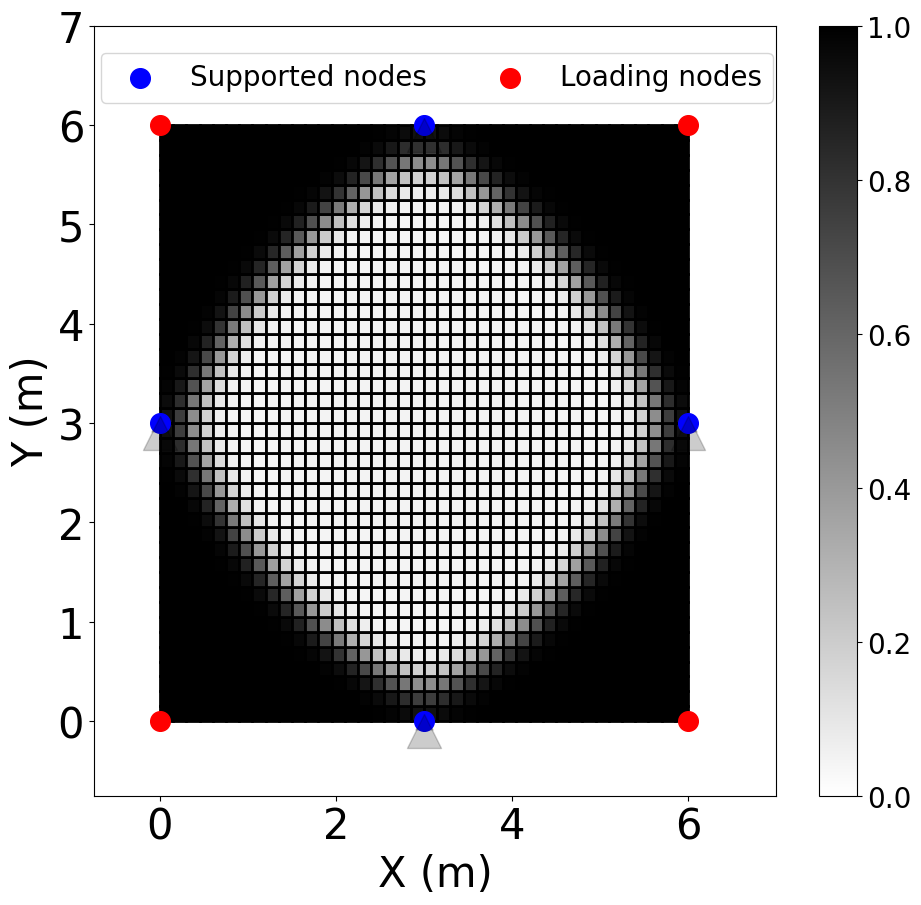

 52%|█████▏    | 55/105 [04:55<04:02,  4.85s/it]

Iter55, alpha=2.85, p=5.3
Train epoch 57  ,loss:0.02204597594729657


 53%|█████▎    | 56/105 [04:59<03:51,  4.72s/it]

Iter56, alpha=2.9000000000000004, p=5.359999999999999
Train epoch 58  ,loss:0.021885145895857196


 54%|█████▍    | 57/105 [05:04<03:41,  4.62s/it]

Iter57, alpha=2.95, p=5.42
Train epoch 59  ,loss:0.021960313674330965


 55%|█████▌    | 58/105 [05:08<03:33,  4.55s/it]

Iter58, alpha=3.0000000000000004, p=5.48
Train epoch 60  ,loss:0.021818997540712655


 56%|█████▌    | 59/105 [05:13<03:26,  4.50s/it]

Iter59, alpha=3.0500000000000003, p=5.54
Train epoch 61  ,loss:0.021880160269781082
805.6824935227131


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


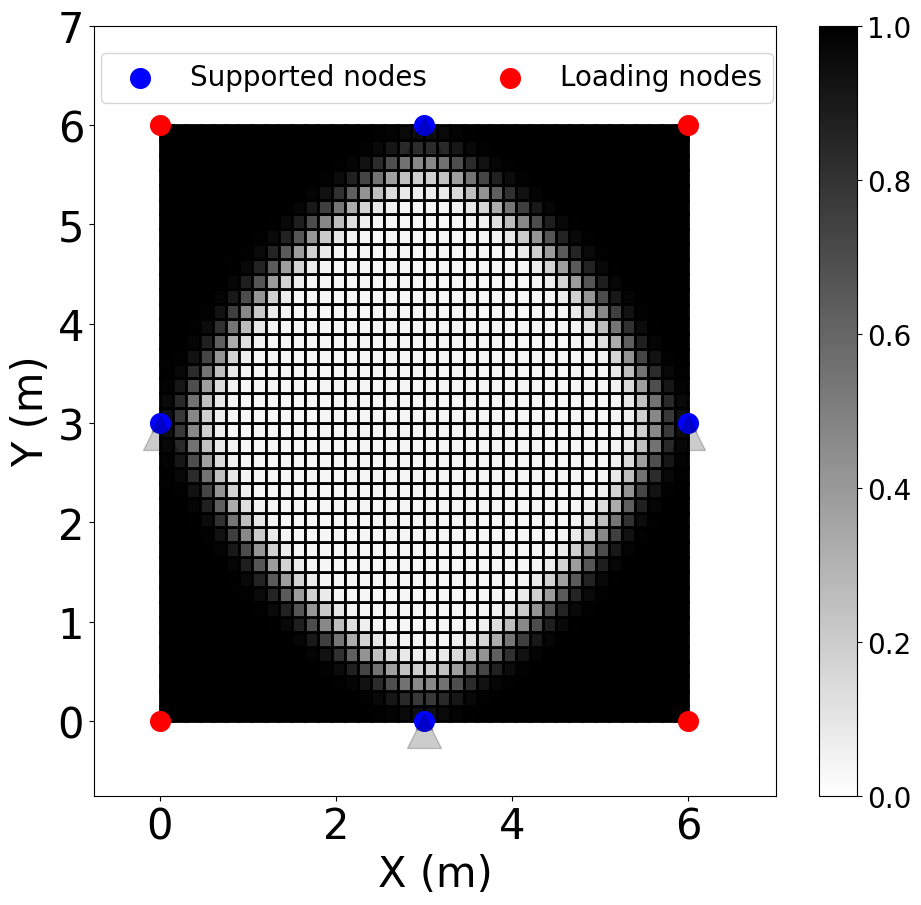

 57%|█████▋    | 60/105 [05:19<03:42,  4.94s/it]

Iter60, alpha=3.1, p=5.6
Train epoch 62  ,loss:0.02177718182720864


 58%|█████▊    | 61/105 [05:23<03:30,  4.79s/it]

Iter61, alpha=3.1500000000000004, p=5.66
Train epoch 63  ,loss:0.021755903947359215


 59%|█████▉    | 62/105 [05:27<03:20,  4.67s/it]

Iter62, alpha=3.2, p=5.72
Train epoch 64  ,loss:0.021660770469501284


 60%|██████    | 63/105 [05:32<03:12,  4.58s/it]

Iter63, alpha=3.2500000000000004, p=5.779999999999999
Train epoch 65  ,loss:0.021603630237719457


 61%|██████    | 64/105 [05:36<03:05,  4.52s/it]

Iter64, alpha=3.3000000000000003, p=5.84
Train epoch 66  ,loss:0.02151139895735034
799.8737745764787


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


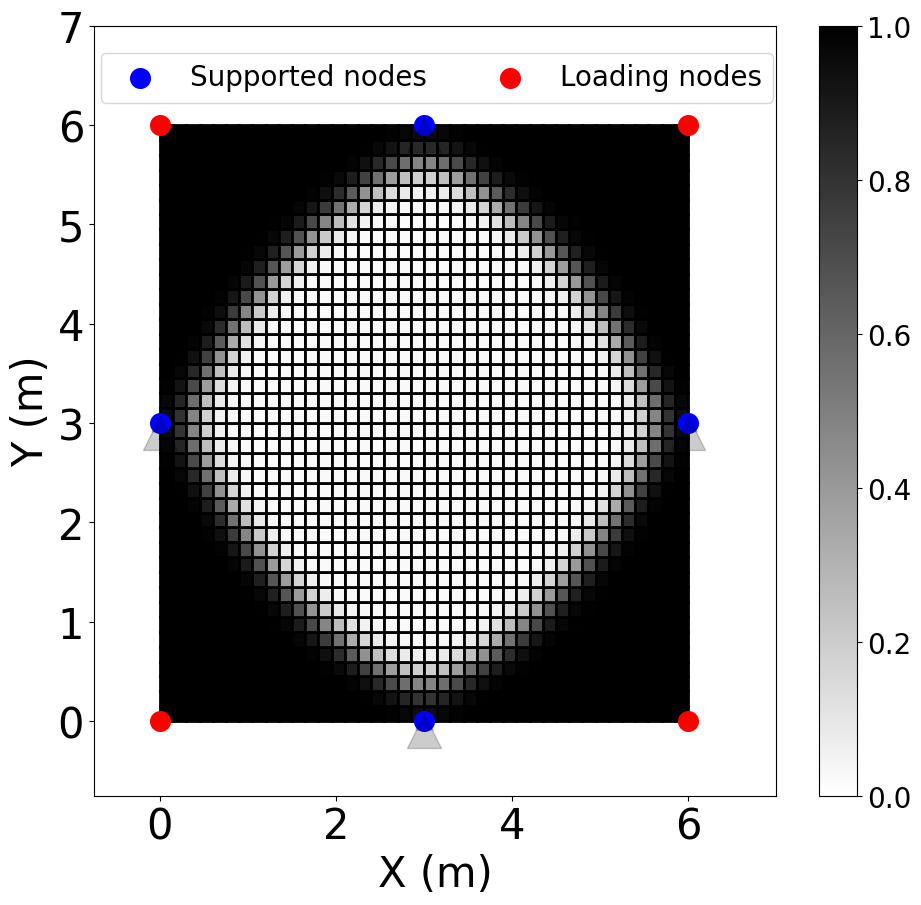

 62%|██████▏   | 65/105 [05:42<03:14,  4.85s/it]

Iter65, alpha=3.35, p=5.9
Train epoch 67  ,loss:0.02147866853151151


 63%|██████▎   | 66/105 [05:46<03:03,  4.71s/it]

Iter66, alpha=3.4000000000000004, p=5.96
Train epoch 68  ,loss:0.021418979853708036


 64%|██████▍   | 67/105 [05:51<02:54,  4.60s/it]

Iter67, alpha=3.45, p=6.02
Train epoch 69  ,loss:0.021389627621982963


 65%|██████▍   | 68/105 [05:55<02:47,  4.53s/it]

Iter68, alpha=3.5000000000000004, p=6.08
Train epoch 70  ,loss:0.021334962665021488


 66%|██████▌   | 69/105 [05:59<02:41,  4.48s/it]

Iter69, alpha=3.5500000000000003, p=6.14
Train epoch 71  ,loss:0.021302757996079016
800.5606651280029


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


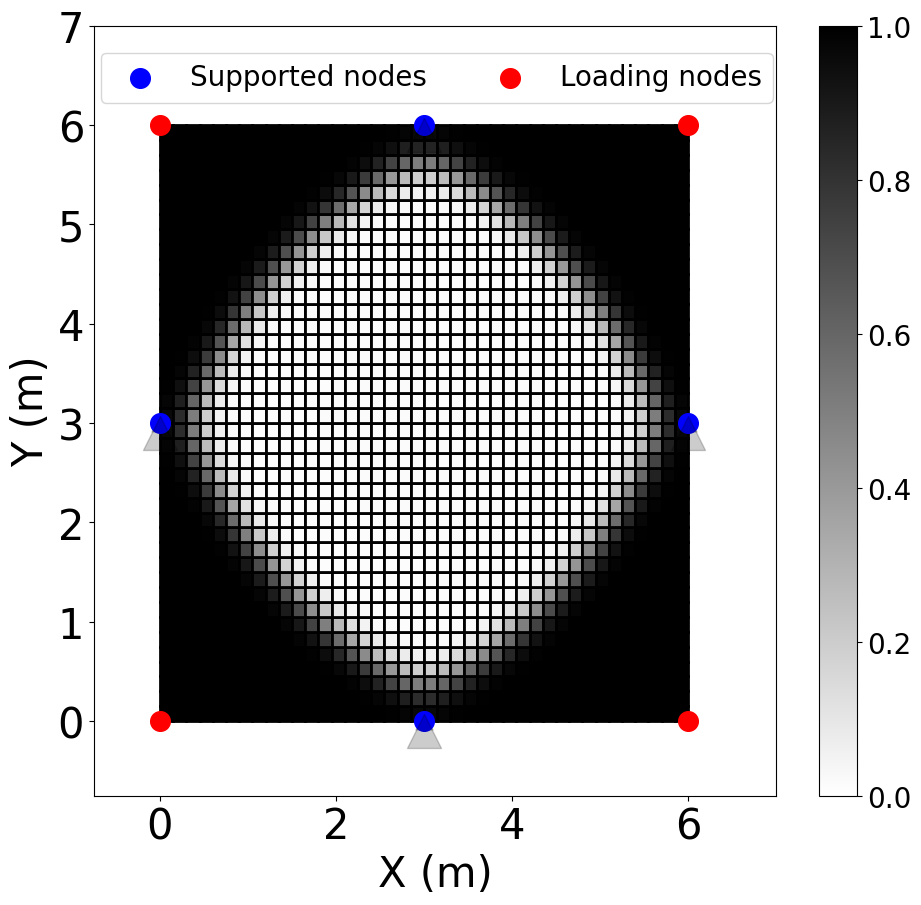

 67%|██████▋   | 70/105 [06:05<02:48,  4.81s/it]

Iter70, alpha=3.6, p=6.2
Train epoch 72  ,loss:0.021264873642881498


 68%|██████▊   | 71/105 [06:09<02:38,  4.68s/it]

Iter71, alpha=3.6500000000000004, p=6.26
Train epoch 73  ,loss:0.021240666903440245


 69%|██████▊   | 72/105 [06:14<02:31,  4.58s/it]

Iter72, alpha=3.7, p=6.32
Train epoch 74  ,loss:0.02121066063956716


 70%|██████▉   | 73/105 [06:18<02:24,  4.52s/it]

Iter73, alpha=3.7500000000000004, p=6.38
Train epoch 75  ,loss:0.021195818437310752


 70%|███████   | 74/105 [06:22<02:18,  4.46s/it]

Iter74, alpha=3.8000000000000003, p=6.4399999999999995
Train epoch 76  ,loss:0.021168866745538938
803.6366241001979


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


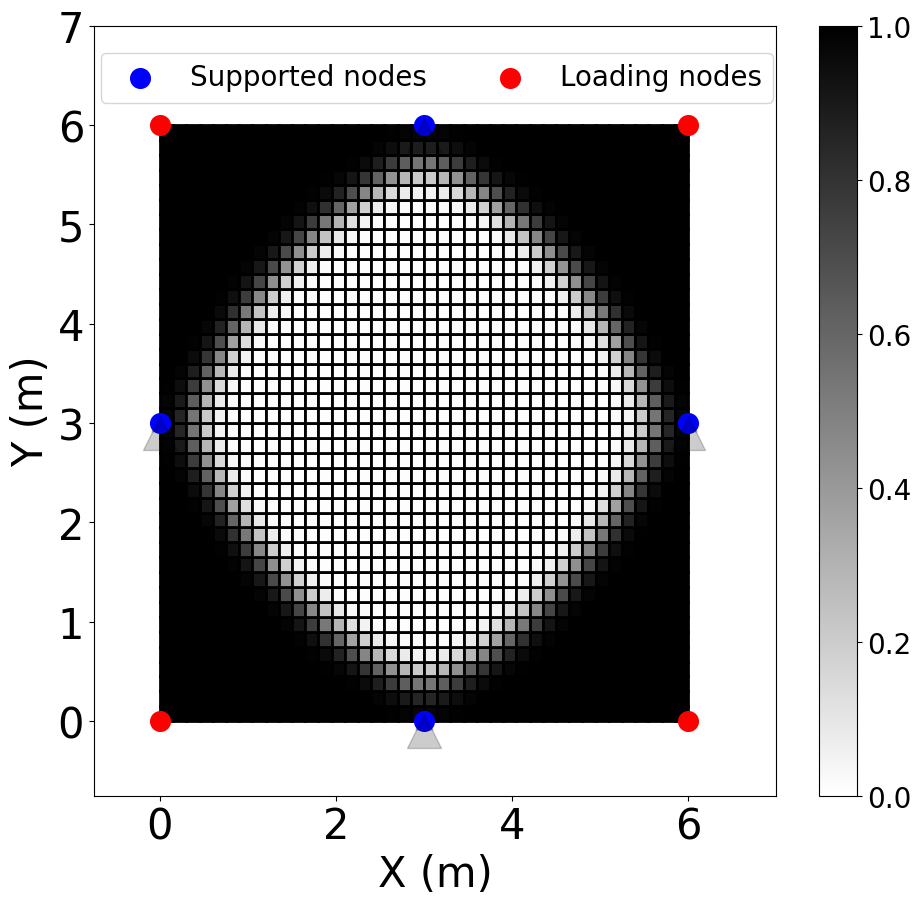

 71%|███████▏  | 75/105 [06:28<02:27,  4.93s/it]

Iter75, alpha=3.85, p=6.5
Train epoch 77  ,loss:0.021160055617733577


 72%|███████▏  | 76/105 [06:33<02:17,  4.75s/it]

Iter76, alpha=3.9000000000000004, p=6.56
Train epoch 78  ,loss:0.02113313416888148


 73%|███████▎  | 77/105 [06:37<02:09,  4.61s/it]

Iter77, alpha=3.95, p=6.62
Train epoch 79  ,loss:0.021127551018063354


 74%|███████▍  | 78/105 [06:41<02:02,  4.52s/it]

Iter78, alpha=4.0, p=6.68
Train epoch 80  ,loss:0.021097858056141852


 75%|███████▌  | 79/105 [06:46<01:55,  4.45s/it]

Iter79, alpha=4.05, p=6.74
Train epoch 81  ,loss:0.02109587112365991
801.9934597885549


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


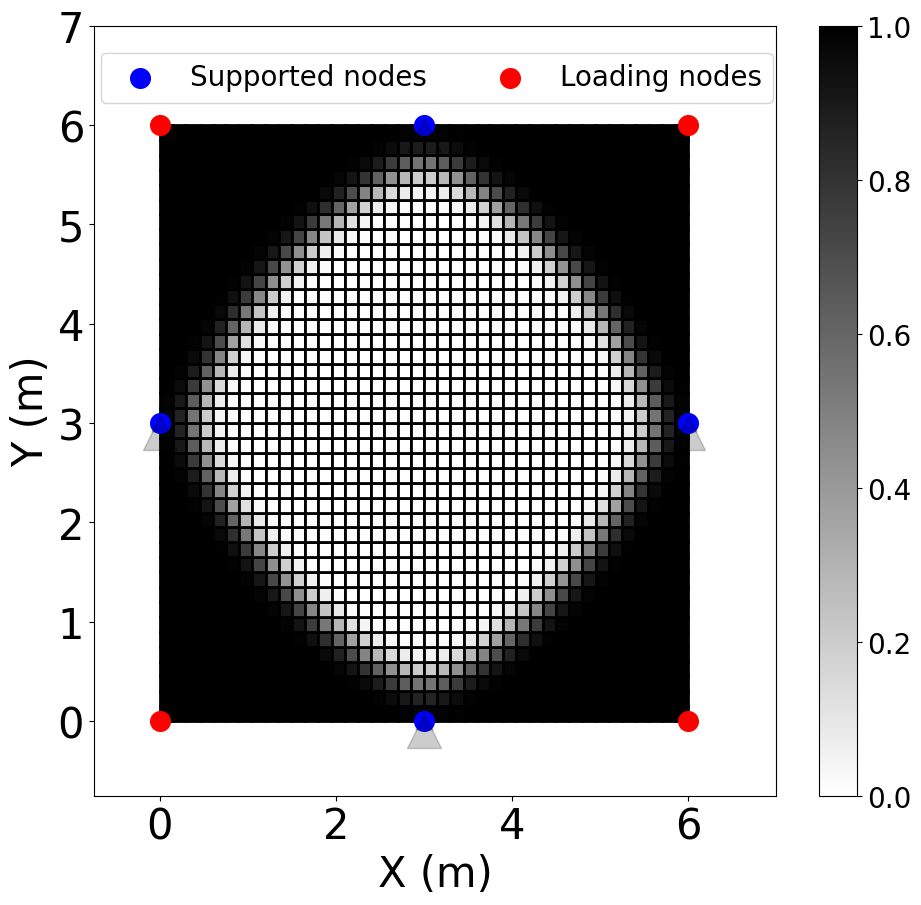

 76%|███████▌  | 80/105 [06:51<01:59,  4.77s/it]

Iter80, alpha=4.1, p=6.8
Train epoch 82  ,loss:0.021063145437627884


 77%|███████▋  | 81/105 [06:55<01:50,  4.62s/it]

Iter81, alpha=4.1499999999999995, p=6.859999999999999
Train epoch 83  ,loss:0.02105653876787085


 78%|███████▊  | 82/105 [07:00<01:43,  4.52s/it]

Iter82, alpha=4.2, p=6.92
Train epoch 84  ,loss:0.021033232344489745


 79%|███████▉  | 83/105 [07:04<01:37,  4.45s/it]

Iter83, alpha=4.25, p=6.9799999999999995
Train epoch 85  ,loss:0.02101479450290971


 80%|████████  | 84/105 [07:08<01:32,  4.41s/it]

Iter84, alpha=4.3, p=7.04
Train epoch 86  ,loss:0.021007803185759764
802.303541433153


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


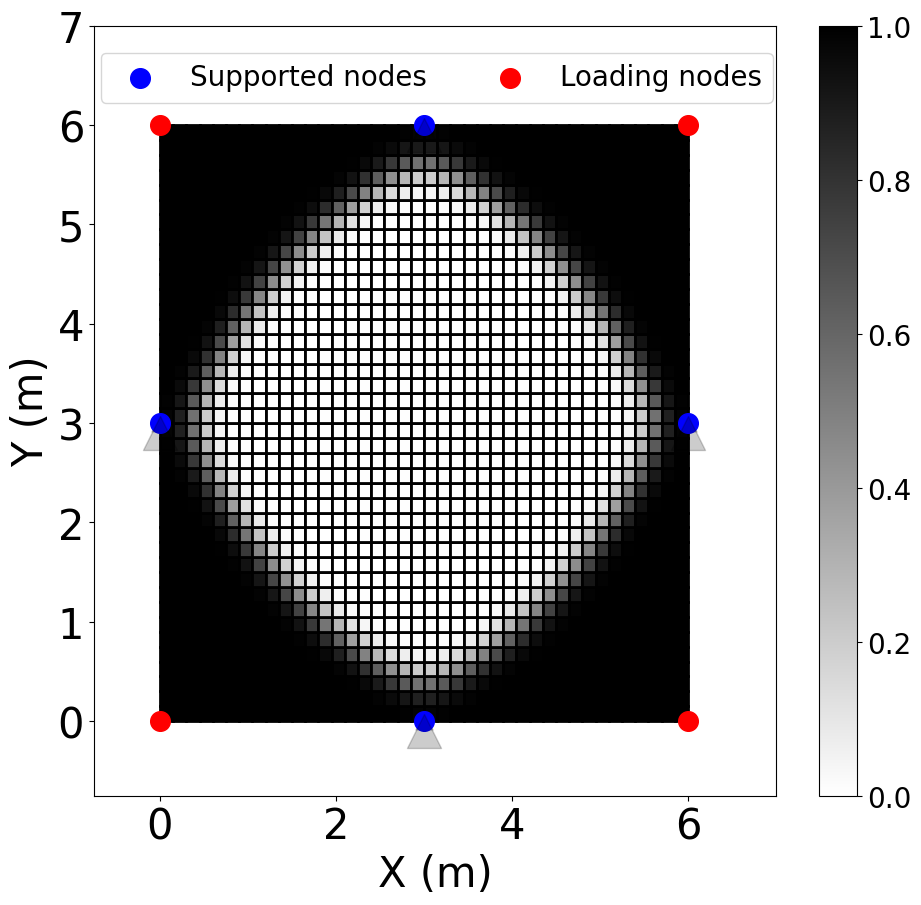

 81%|████████  | 85/105 [07:14<01:37,  4.86s/it]

Iter85, alpha=4.35, p=7.1
Train epoch 87  ,loss:0.020982998242140595


 82%|████████▏ | 86/105 [07:18<01:28,  4.68s/it]

Iter86, alpha=4.3999999999999995, p=7.16
Train epoch 88  ,loss:0.020967078874911334


 83%|████████▎ | 87/105 [07:23<01:22,  4.59s/it]

Iter87, alpha=4.45, p=7.22
Train epoch 89  ,loss:0.020959386552881522


 84%|████████▍ | 88/105 [07:27<01:16,  4.49s/it]

Iter88, alpha=4.5, p=7.279999999999999
Train epoch 90  ,loss:0.02094002112416643


 85%|████████▍ | 89/105 [07:31<01:10,  4.41s/it]

Iter89, alpha=4.55, p=7.34
Train epoch 91  ,loss:0.02091632739470922


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


801.5105984392085


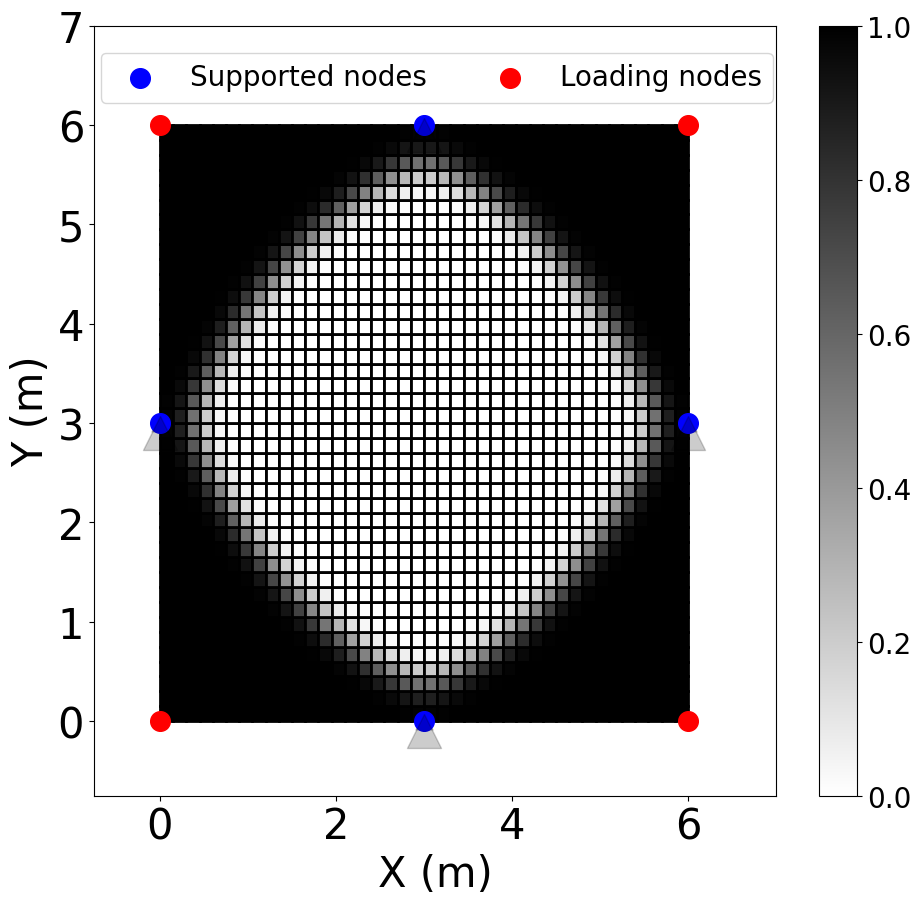

 86%|████████▌ | 90/105 [07:37<01:10,  4.72s/it]

Iter90, alpha=4.6, p=7.3999999999999995
Train epoch 92  ,loss:0.020901415973109128


 87%|████████▋ | 91/105 [07:41<01:04,  4.59s/it]

Iter91, alpha=4.6499999999999995, p=7.46
Train epoch 93  ,loss:0.020891405725794825


 88%|████████▊ | 92/105 [07:45<00:58,  4.49s/it]

Iter92, alpha=4.7, p=7.52
Train epoch 94  ,loss:0.020884369715287062


 89%|████████▊ | 93/105 [07:49<00:53,  4.42s/it]

Iter93, alpha=4.75, p=7.58
Train epoch 95  ,loss:0.020874299586333116


 90%|████████▉ | 94/105 [07:54<00:48,  4.37s/it]

Iter94, alpha=4.8, p=7.64
Train epoch 96  ,loss:0.020860413694392056
802.9221190701909


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


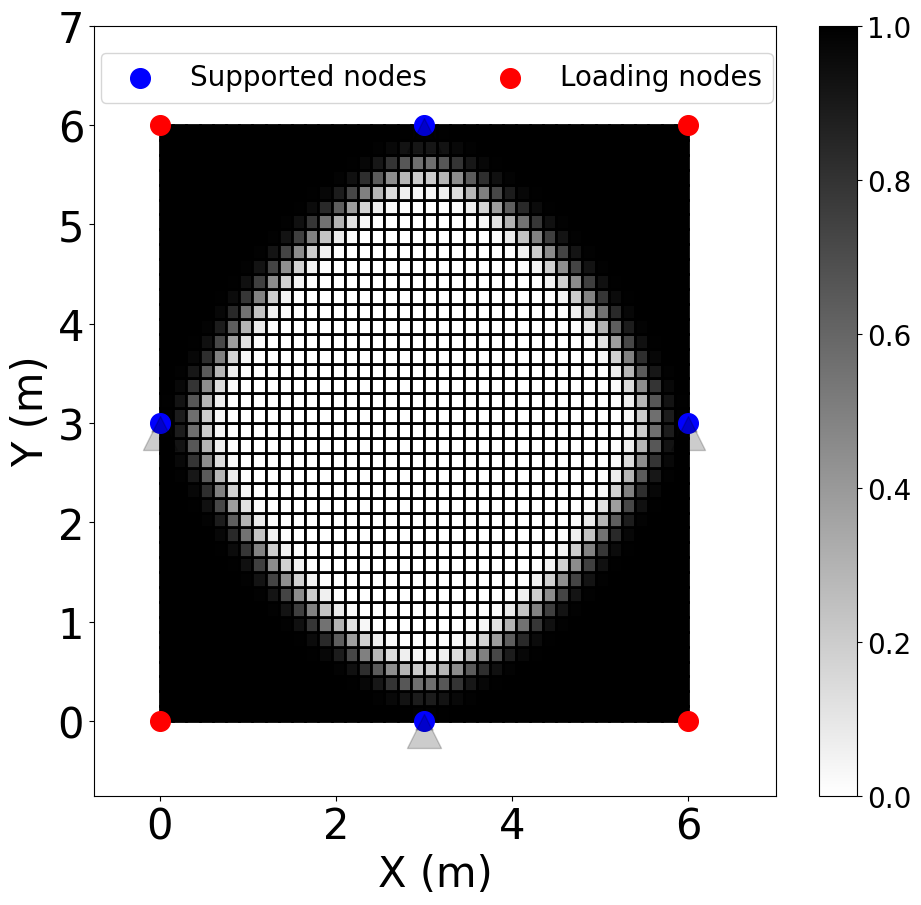

 90%|█████████ | 95/105 [07:59<00:46,  4.70s/it]

Iter95, alpha=4.85, p=7.7
Train epoch 97  ,loss:0.020837763675129756


 91%|█████████▏| 96/105 [08:03<00:41,  4.56s/it]

Iter96, alpha=4.9, p=7.76
Train epoch 98  ,loss:0.02081551718563121


 92%|█████████▏| 97/105 [08:08<00:35,  4.48s/it]

Iter97, alpha=4.95, p=7.819999999999999
Train epoch 99  ,loss:0.020796993386237334


 93%|█████████▎| 98/105 [08:12<00:30,  4.40s/it]

Iter98, alpha=5.0, p=7.88
Train epoch 100  ,loss:0.020782344116631355


 94%|█████████▍| 99/105 [08:16<00:26,  4.36s/it]

Iter99, alpha=5.05, p=7.9399999999999995
Train epoch 101  ,loss:0.0207708272984564
802.6193384761573


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


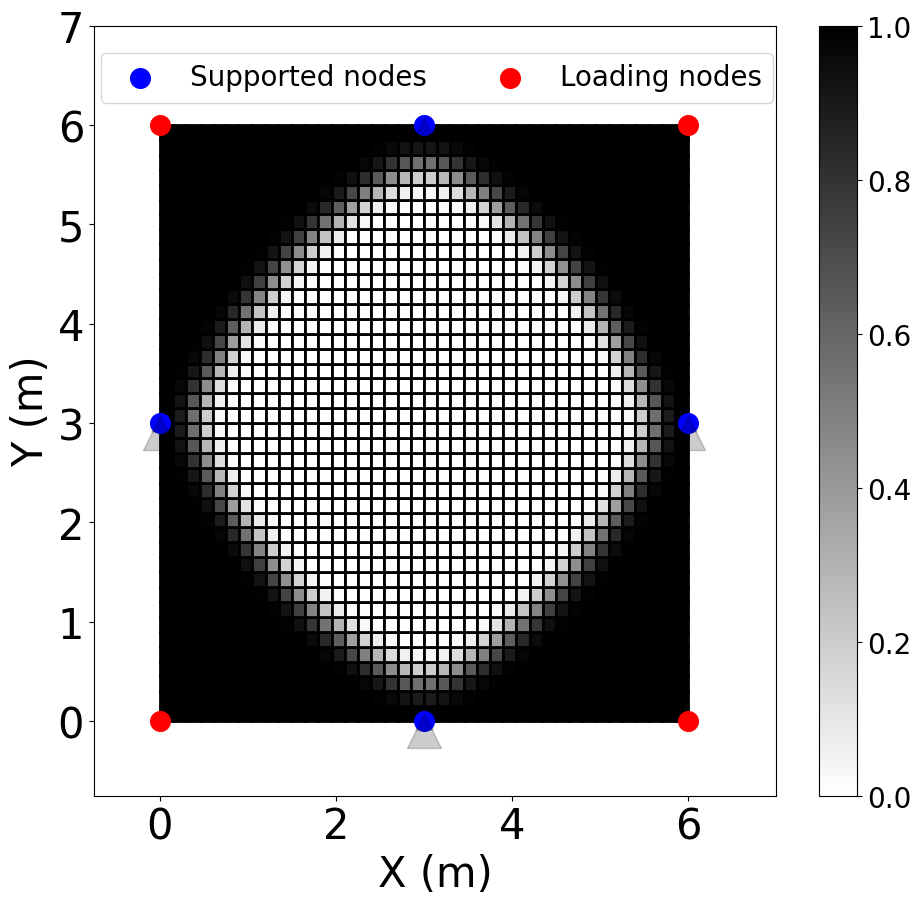

 95%|█████████▌| 100/105 [08:22<00:24,  4.83s/it]

Iter100, alpha=5.1, p=8.0
Train epoch 102  ,loss:0.02076401398186661


 96%|█████████▌| 101/105 [08:26<00:18,  4.66s/it]

Iter101, alpha=5.15, p=8.0
Train epoch 103  ,loss:0.020759635834716107


 97%|█████████▋| 102/105 [08:31<00:13,  4.54s/it]

Iter102, alpha=5.2, p=8.0
Train epoch 104  ,loss:0.020779980774341813


 98%|█████████▊| 103/105 [08:35<00:08,  4.45s/it]

Iter103, alpha=5.25, p=8.0
Train epoch 105  ,loss:0.020859558791362684


 99%|█████████▉| 104/105 [08:39<00:04,  4.40s/it]

Iter104, alpha=5.3, p=8.0
Train epoch 106  ,loss:0.020888337454361947
797.6630070733382


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


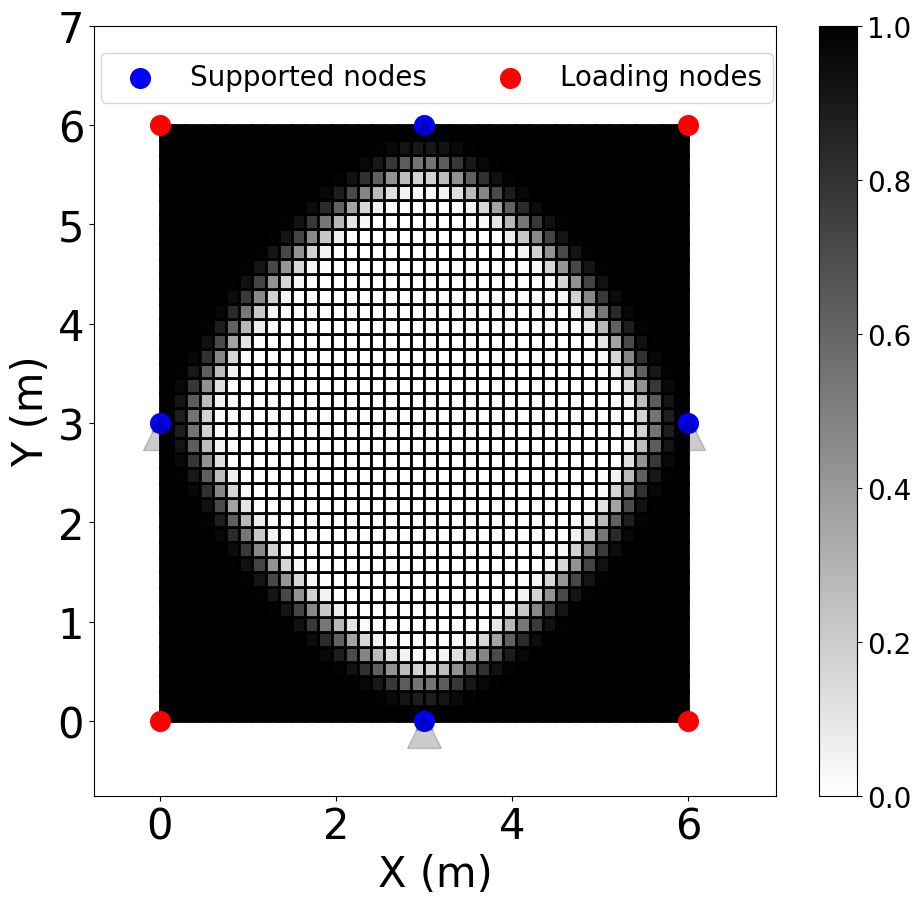

100%|██████████| 105/105 [08:45<00:00,  5.00s/it]


In [70]:
trained_model_state = train_model(model_state, num_epochs=105)

In [71]:
##Apply_fn: ML input to output
outs = trained_model_state.apply_fn(trained_model_state.params, inp) #how to move nodes along z, ML-Outpu
node_params = outs[:,0]
node_rho_params = outs[:,1]

#Final-Z
zs[design_nodes] = og_p(node_params)
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

#Final density
mu_opt = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell

In [72]:
print(loss_list[0],loss_list[104])

1.3167168778260279 0.020888337454361947


In [73]:
(comp_list[0]-comp_list[104])/comp_list[0]

Array(0.91635634, dtype=float64)

In [74]:
comp_list[0]

Array(149.05537777, dtype=float64)

In [75]:
comp_list[104]

Array(12.46753791, dtype=float64)

In [76]:
(np.sqrt(np.array(v_list)+1)*800/1600*100)[104]

50.00021828925024

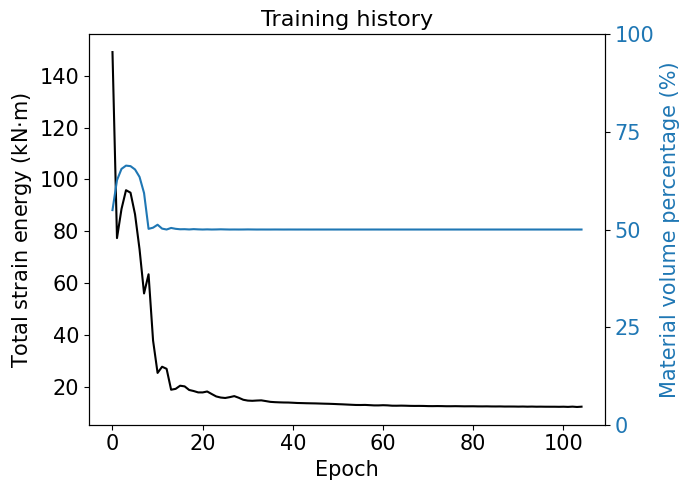

In [77]:
iteration = np.arange(0,len(comp_list),1)


fig, ax1 = plt.subplots(figsize=(7,5))

color = 'k'
ax1.set_xlabel('Epoch',fontsize=15)
ax1.set_ylabel(r'Total strain energy (kN$\cdot$m)',color=color,fontsize=15)
ax1.plot(iteration, np.array(comp_list), color=color)
ax1.tick_params(axis='both', labelcolor=color, which='major', labelsize=15)
#ax1.set_yticks(np.linspace(0,2,5))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Material volume percentage (%)', color=color,fontsize=15)  # we already handled the x-label with ax1
ax2.plot(iteration, np.sqrt(np.array(v_list)+1)*800/1600*100, color=color)
ax2.tick_params(axis='both', labelcolor=color, which='major', labelsize=15)
ax2.set_yticks(np.linspace(0,100,5))

plt.title('Training history',fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Text(0, 0.5, 'Loss')

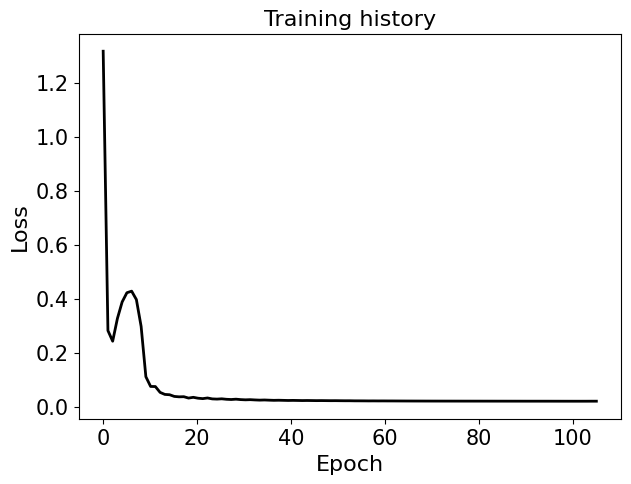

In [78]:

n_iter = np.array(loss_list).shape[0]
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(np.linspace(0,n_iter,n_iter),np.array(loss_list),'-k',linewidth=2)
plt.xticks(np.linspace(0,100,6),fontsize=15)
plt.yticks(fontsize=15)
#ax.set_ylim(-200,5000)
plt.xlabel('Epoch',fontsize=16)
plt.title('Training history',fontsize=16)
plt.ylabel(r'Loss',fontsize=16)

In [79]:
(loss_list[0]-loss_list[104])/loss_list[0]

Array(0.98413604, dtype=float64)

# Visualization

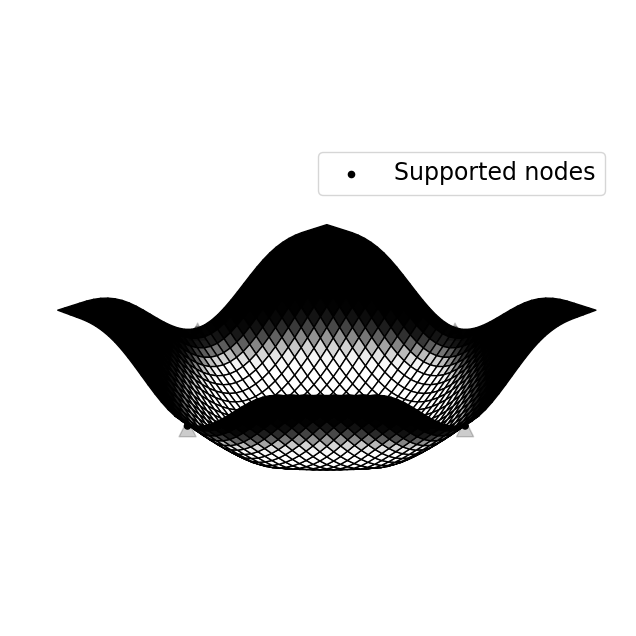

In [80]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
ax.set_xlim(0,6)
ax.set_ylim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    #all_corners.append([[xs[inode],ys[inode],zs[inode]],
    #                    [xs[jnode],ys[jnode],zs[jnode]],
    #                    [xs[mnode],ys[mnode],zs[mnode]],
    #                    [xs[nnode],ys[nnode],zs[nnode]],
    #                   ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.05,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.1,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20,45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.axis('off')
plt.show()

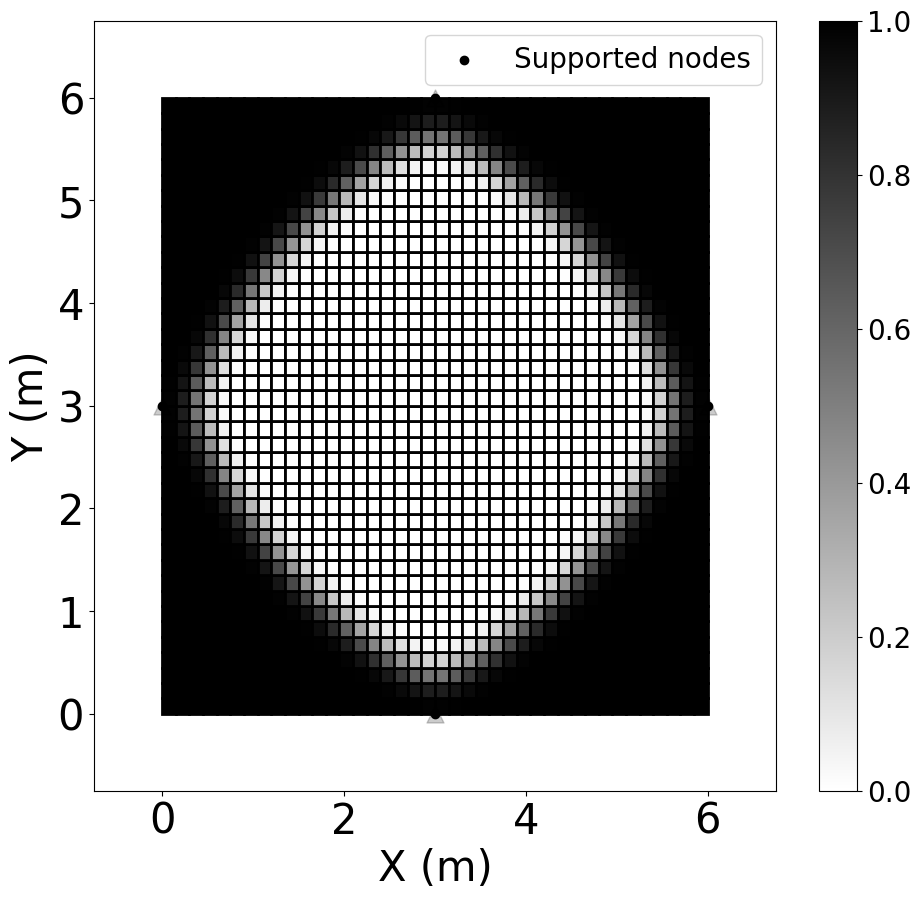

In [81]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

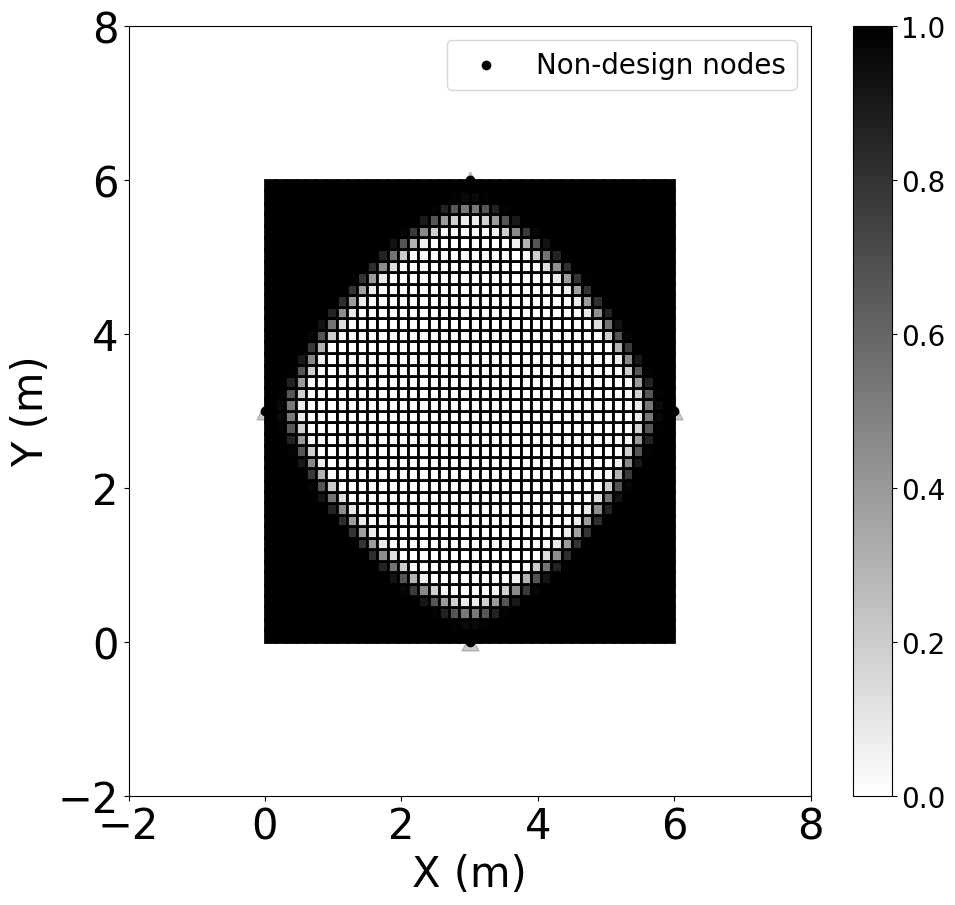

In [82]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [40]:
jnp.sum(mu_opt)

Array(777.42484312, dtype=float64)

In [107]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [108]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered

In [82]:
jnp.min(mu_opt)

Array(0.49547004, dtype=float64)

In [83]:
jnp.max(mu_opt)

Array(0.54537502, dtype=float64)

In [86]:
jnp.max(model_state.apply_fn(params, inp)[:,1])

Array(0.52117628, dtype=float64)

In [87]:
jnp.min(model_state.apply_fn(params, inp)[:,1])

Array(0.5, dtype=float64)

In [89]:
np.max(zs)

1.827663999013847

In [90]:
np.min(zs)

1.4122399536942798